In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!python -c "import transformers" || pip install transformers
!python -c "import datasets" || pip install datasets

In [ ]:
import torch
import numpy as np
from collections import Counter
from transformers import BertTokenizer, BertModel
from datasets import load_dataset

### BERT: Model Structure

In [ ]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

In [ ]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
bert_model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

### IMDB Dataset

https://huggingface.co/datasets/imdb

In [ ]:
# Load IMDb dataset from Hugging Face
dataset = load_dataset("imdb")
dataset

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
# Extract text and labels from the dataset
texts_train = dataset['train']['text']
labels_train = dataset['train']['label']
texts_test = dataset['test']['text']
labels_test = dataset['test']['label']

In [ ]:
print(f'training set sample size: {len(texts_train)}')
print(dict(Counter(labels_train)))
print(f'example:')
for idx, text in enumerate(texts_train[:5]):
    print(f'[{idx}] {text}')

print(f'\ntesting set sample size: {len(texts_test)}')
print(dict(Counter(labels_test)))
print(f'example:')
for idx, text in enumerate(texts_test[:5]):
    print(f'[{idx}] {text}')

training set sample size: 25000
{0: 12500, 1: 12500}
example:
[0] I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornograph

### Sentiment Analysis

#### Data Cleaning and Preprocessing

##### Removing HTML syntaxes, URLs, Emojis

In [ ]:
import re

def remove_html(data):
    html_tag = re.compile(r'<.*?>')
    data = html_tag.sub(r'', data)
    return data

# Removes URLs
def remove_url(data):
    url_clean = re.compile(r"https://\S+|www\.\S+")
    data = url_clean.sub(r'', data)
    return data

# Removes Emojis
def remove_emoji(data):
    emoji_clean= re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
    data = emoji_clean.sub(r'', data)
    return data

In [ ]:
def text_cleaning(data, fun_list):
    """
    :param data: a list of texts
    :param fun_list: a list of functions
    :return: a list of texts
    """
    for fun in fun_list:
        print('Processing: ' + fun.__name__ + '...')
        data = list(map(fun, data))
    return data

##### Comparison: before-and-after cleaning

In [ ]:
texts_train = dataset['train']['text']
print('Text before cleaning:')
for idx, text in enumerate(texts_train[:10]):
    print(f'[{idx}] {text}')

Text before cleaning:
[0] I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes ar

Processing training text.

In [ ]:
texts_train = text_cleaning(texts_train, [remove_html, remove_url, remove_emoji])
print('\nText after cleaning:')
for idx, text in enumerate(texts_train[:10]):
    print(f'[{idx}] {text}')

Processing: remove_html...
Processing: remove_url...
Processing: remove_emoji...

Text after cleaning:
[0] I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was cons

Processing test text.

In [ ]:
texts_test = text_cleaning(texts_test, [remove_html, remove_url, remove_emoji])

Processing: remove_html...
Processing: remove_url...
Processing: remove_emoji...


#### Tokenization

##### Distribution of token length in training set

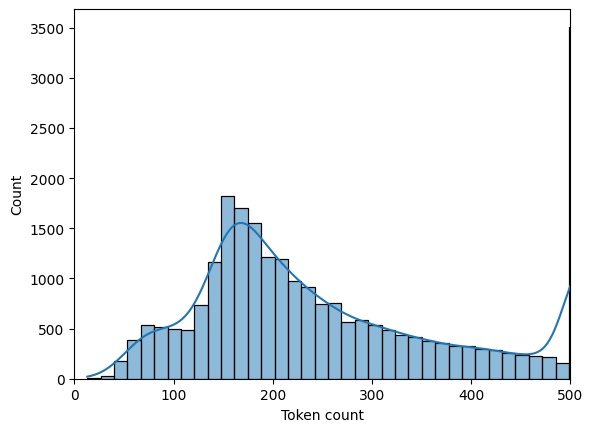

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

token_lens = []
for txt in texts_train:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))
sns.histplot(token_lens, kde=True)
plt.xlim([0, 500])
plt.xlabel('Token count')
plt.show()

In [ ]:
# Tokenize and pad input sequences
def tokenize(texts, max_length):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

Set `max_length=512`.

In [ ]:
input_ids_train, attention_masks_train = tokenize(texts_train, max_length=512)
input_ids_test, attention_masks_test = tokenize(texts_test, max_length=512)

In [ ]:
labels_train = torch.tensor(labels_train)
labels_test = torch.tensor(labels_test)

In [ ]:
print(input_ids_train.shape)
print(attention_masks_train.shape)
print(labels_train.shape)

torch.Size([25000, 512])
torch.Size([25000, 512])
torch.Size([25000])


In [ ]:
torch.save(input_ids_train, '../data/input_ids_train.pt')
torch.save(input_ids_test, '../data/input_ids_test.pt')
torch.save(attention_masks_train, '../data/attention_masks_train.pt')
torch.save(attention_masks_test, '../data/attention_masks_test.pt')

#### Embedding

For BERT, the output `model(input)` contains two elements:

- `last_hidden_state`:
- `pooler_output`:

We use `last_hidden_state [CLS]` here.

In [ ]:
# Extract BERT embeddings for the training and validation data
def extract_bert_embeddings(model, input_ids, attention_masks, batch_size):
    embeddings_hidden = []
    # embeddings_pool = []
    with torch.no_grad():
        for i in range(0, len(input_ids), batch_size):
            if i % 1000 == 0:
                print(f'Processing for: {i}...')
            batch_input_ids = input_ids[i:(i+batch_size)].to(device)
            batch_attention_masks = attention_masks[i:(i+batch_size)].to(device)
            outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
            # last_hidden_state [CLS]
            embeddings_hidden.append(outputs.last_hidden_state[:,0,:].cpu().numpy())
    return np.vstack(embeddings_hidden)

##### Embedding for training set

In [ ]:
embeddings_train = extract_bert_embeddings(bert_model, input_ids_train, attention_masks_train, batch_size=10)

Processing for: 0...
Processing for: 1000...
Processing for: 2000...
Processing for: 3000...
Processing for: 4000...
Processing for: 5000...
Processing for: 6000...
Processing for: 7000...
Processing for: 8000...
Processing for: 9000...
Processing for: 10000...
Processing for: 11000...
Processing for: 12000...
Processing for: 13000...
Processing for: 14000...
Processing for: 15000...
Processing for: 16000...
Processing for: 17000...
Processing for: 18000...
Processing for: 19000...
Processing for: 20000...
Processing for: 21000...
Processing for: 22000...
Processing for: 23000...
Processing for: 24000...


In [ ]:
print(embeddings_train.shape)
np.save('../data/IMDb_BERT_base_CLS_embedding_train.npy', embeddings_train)

(25000, 768)


##### Embedding for testing set

In [ ]:
embeddings_test = extract_bert_embeddings(bert_model, input_ids_test, attention_masks_test, batch_size=10)

Processing for: 0...
Processing for: 1000...
Processing for: 2000...
Processing for: 3000...
Processing for: 4000...
Processing for: 5000...
Processing for: 6000...
Processing for: 7000...
Processing for: 8000...
Processing for: 9000...
Processing for: 10000...
Processing for: 11000...
Processing for: 12000...
Processing for: 13000...
Processing for: 14000...
Processing for: 15000...
Processing for: 16000...
Processing for: 17000...
Processing for: 18000...
Processing for: 19000...
Processing for: 20000...
Processing for: 21000...
Processing for: 22000...
Processing for: 23000...
Processing for: 24000...


In [ ]:
print(embeddings_test.shape)
np.save('../data/IMDb_BERT_base_CLS_embedding_test.npy', embeddings_test)

(25000, 768)


In [ ]:
# Construct dataset
X_train = embeddings_train
y_train = np.array(labels_train)
X_test = embeddings_test
y_test = np.array(labels_test)

print('Training Set:', np.shape(X_train), np.shape(y_train))
print(dict(Counter(y_train)))
print('Testing Set:', np.shape(X_test), np.shape(y_test))
print(dict(Counter(y_test)))

np.save('../data/IMDb_BERT_base_CLS_labels_train.npy', y_train)
np.save('../data/IMDb_BERT_base_CLS_labels_test.npy', y_test)

Training Set: (25000, 768) (25000,)
{0: 12500, 1: 12500}
Testing Set: (25000, 768) (25000,)
{0: 12500, 1: 12500}
